# Initial data read (Oxford St. Ebbes)
Notebook to begin exploring the UK air pollution data made available by the department for environment, food and rural affairs: [UK Air Information Resource](https://uk-air.defra.gov.uk/).

&copy; Crown 2020 copyright Defra via uk-air.defra.gov.uk, licenced under the [Open Government Licence (OGL)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/2/).  
  
First, we will inspect air pollution readings from a measurement station in Oxford, UK.  
  
  
To find data for a new site, follow these steps:
- Open the [monitoring site search](https://uk-air.defra.gov.uk/networks/find-sites) at the UK Air Information Resource website.
- Select a monitoring network of interest: all data processing code and notebooks have used the 'Automatic Urban and Rural Monitoring Network' (AURN).
- Choose to search by postcode or region. Select 'Search Network' or 'Search Region' to see a list of results.
- Find a site of interest from the results table; select 'View site networks and parameters' from the 'Further information' column.
- Select the 'Networks' tab on the site information page; select 'Pre-Formatted Data Files'.
- This page will display the available years of air pollution data for the chosen site; the URL of this page will end with a 'site_id' code: this code should be used to define the 'location' variable in the notebook below. Similarly, the available years can be used to define the 'start_year' and 'end_year' variables.


Notebook successfully:
- Achieves initial read-in of air pollution data, by default from Oxford St. Ebbes measurement station
- Prints out summaries on data availability and visualises this data as heatmaps

In [1]:
%load_ext autoreload
%load_ext watermark
%load_ext lab_black

In [2]:
%autoreload 2

In [3]:
%watermark -ntz -p pandas -a Simon-Lee-UK

Simon-Lee-UK Sun Oct 04 2020 17:36:40 BST 

pandas 1.1.2


In [4]:
import sys
import time
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

repo_root = Path.cwd().resolve().parent

sys.path.append(str(repo_root))
interim_data_path = repo_root / "data" / "interim"
interim_data_path.mkdir(parents=True, exist_ok=True)

from src.inspect_site import preview_data, monitoring_site_summary

## Data info
Location: Oxford St Ebbes (OX8)
All Data GMT hour ending  
Status: R = Ratified / P = Provisional / P* = As supplied  
Data available: 2008 - 2020

## Preview data and identify available years
First, we use a custom 'preview data' function to return a small sample of data from a single year's data set. 
We start by defining the range of years we may want to download data for; we also define the location of interest as described at the top of the notebook:

In [5]:
location = "OX8"
start_year = 2007
end_year = 2020

Next, we call the preview_data function with this information:

In [6]:
preview_df, valid_data_years = preview_data(location, start_year, end_year)

Generating data preview:  93%|█████████▎| 13/14 [00:15<00:01,  1.13s/it]

-------
WARNING
-------
Could not read data from: https://uk-air.defra.gov.uk/data_files/site_data/OX8_2007.csv
Check the URL to ensure location code, year and file extension are all valid!


Generating data preview: 100%|██████████| 14/14 [00:15<00:00,  1.14s/it]

Preview data sampled from 2020


In [7]:
preview_df.head(3)

,Date,time,PM<sub>10</sub> particulate matter (Hourly measured),status,unit,Nitric oxide,status.1,unit.1,Nitrogen dioxide,status.2,unit.2,Nitrogen oxides as nitrogen dioxide,status.3,unit.3,PM<sub>2.5</sub> particulate matter (Hourly measured),status.4,unit.4
0,01-01-2020,01:00,37.950,R,ugm-3 (FIDAS),0.91869,R,ugm-3,24.21934,R,ugm-3,25.62798,R,ugm-3,31.958,R,ugm-3 (Ref.eq)
1,01-01-2020,02:00,38.125,R,ugm-3 (FIDAS),0.51926,R,ugm-3,24.40668,R,ugm-3,25.20287,R,ugm-3,32.783,R,ugm-3 (Ref.eq)
2,01-01-2020,03:00,40.425,R,ugm-3 (FIDAS),0.23966,R,ugm-3,21.54081,R,ugm-3,21.90828,R,ugm-3,35.661,R,ugm-3 (Ref.eq)


The preview data function failed to find data for 2007, this is communicated by a warning message printed by the function above.  
This missing year of data was therefore not returned in the 'valid_data_years' list, printed below.

In [8]:
valid_data_years

[2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008]

## Generate summary of available site data across multiple years
Data is available for years 2008 - 2020 with access URLs such as: 'https://uk-air.defra.gov.uk/data_files/site_data/OX8_2008.csv' providing the data for each individual year. The 'monitoring_site_summary' function uses this consistent csv file name format to loop through the available years, returning a data dictionary containing all available downloaded data. The function also returns summary tables and plots inspecting differences in available data columns and data consistency for each year; reference can be made to these outputs when attempting to achieve consistent formatting between years e.g. in order to create a single combined data set for all years at a particular site.
  
Using the preview DataFrame above, we can define the variables in the following cell. The first two variables define how 'status' and 'unit' column titles are identified; the second two variables define the relative position of measurement columns with respect to their associated status and unit columns.  
  
These values are all required to generate a summary of monitoring site data at the specified location over all years of interest. For more information on the 'monitoring_site_summary' function see: src.inspect_site or run `help(monitoring_site_summary)` in a notebook cell.

In [9]:
status_str = "status"
unit_str = "unit"
status_offset = -1
unit_offset = -2

Generating summary tables: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]


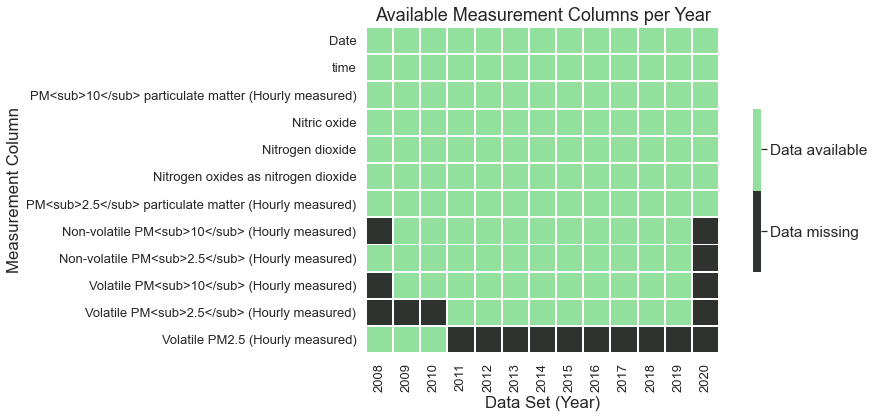

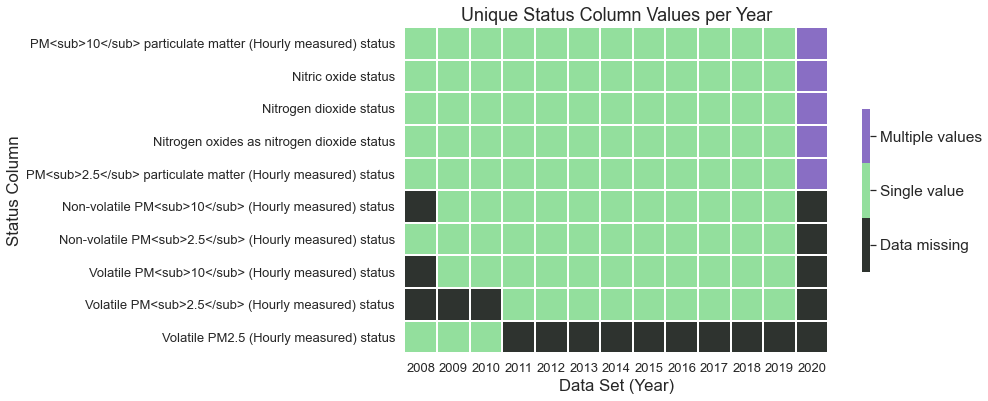

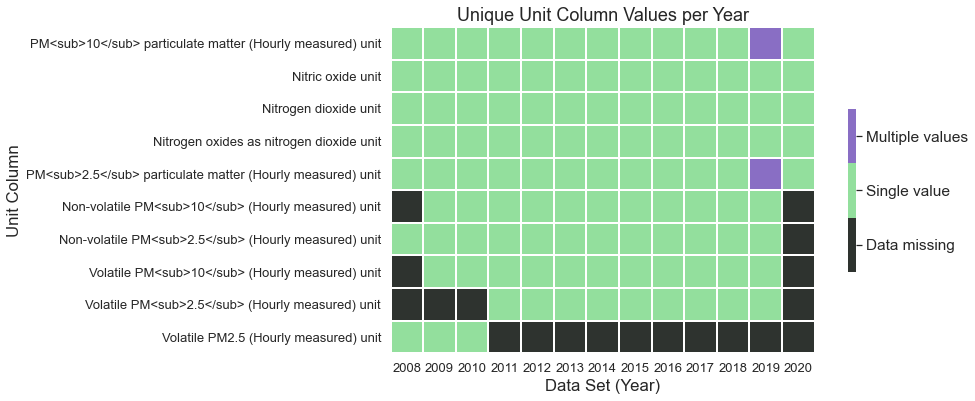

In [10]:
data_dict, measurement_summary, status_summary, unit_summary = monitoring_site_summary(
    location,
    valid_data_years,
    status_str=status_str,
    unit_str=unit_str,
    status_offset=status_offset,
    unit_offset=unit_offset,
)

### Inspecting summary plots
The summary plots above tell us the following:
- Splits between volatile and non-volatile particulate matter readings are not available in 2020 and are largely unavailable for 2008.
- The title of the column reporting volatile particulate matter with diameter $< 2.5 \;\mu m$ changed between 2010 and 2011.
- Multiple different status values are reported for all recorded measurements in 2020; all prior years report only a single status value.
- Multiple different unit values are reported for PM $< 2.5 \;\mu m$ and $< 10 \;\mu m$ measurements in 2019; this suggests the unit for these measurements may have changed during this year.

### Inspecting summary tables
The following tables offer further insight on measurement, status and unit availability/consistency across years of interest.  
Uncomment the following cells to print the full tables.  
  
The following conclusions can be drawn from the summary tables and follow-on cells:
- The 2020 data set contains measurements with both ratified and provisional status, in prior years all entries have been ratified.  
- The update to PM $< 2.5 \;\mu m$ and $< 10 \;\mu m$ unit values in 2019 is confirmed by the 'unit_summary' table; for both measurements the original unit was 'ugm-3 (TEOM FDMS)' and the change took place on 26/06/2019, the new units are:
    - 'ugm-3 (Ref.eq)' ($< 2.5 \;\mu m$)
    - 'ugm-3 (FIDAS)' ($< 10 \;\mu m$)

In [11]:
# measurement_summary

In [12]:
# status_summary

In [13]:
# unit_summary

In [14]:
df_2020 = data_dict[2020].copy()
status_columns = [col for col in df_2020.columns if status_str in col]
status_values_2020 = pd.DataFrame(
    {col: "error" for col in status_columns}, index=["Observed status values"]
)
for column in status_columns:
    status_values_2020.loc["Observed status values (2020)", column] = (
        df_2020[column].unique().tolist()
    )

status_values_2020

,PM<sub>10</sub> particulate matter (Hourly measured) status,Nitric oxide status,Nitrogen dioxide status,Nitrogen oxides as nitrogen dioxide status,PM<sub>2.5</sub> particulate matter (Hourly measured) status
Observed status values,"[R, nan, P]","[R, nan, P]","[R, nan, P]","[R, nan, P]","[R, nan, P]"


In [15]:
df_2018 = data_dict[2018].copy()
df_2019 = data_dict[2019].copy()
target_years = [2018, 2019, 2020]
target_data = [df_2018, df_2019, df_2020]
target_columns = [
    "PM<sub>2.5</sub> particulate matter (Hourly measured) unit",
    "PM<sub>10</sub> particulate matter (Hourly measured) unit",
]
inconsistent_units = pd.DataFrame(
    {col: "error" for col in target_columns}, index=target_years
)
for year, df in zip(target_years, target_data):
    for column in target_columns:
        inconsistent_units.loc[year, column] = df[column].unique().tolist()

inconsistent_units

,PM<sub>2.5</sub> particulate matter (Hourly measured) unit,PM<sub>10</sub> particulate matter (Hourly measured) unit
2018,"[nan, ugm-3 (TEOM FDMS)]","[ugm-3 (TEOM FDMS), nan]"
2019,"[ugm-3 (TEOM FDMS), nan, ugm-3 (Ref.eq)]","[ugm-3 (TEOM FDMS), nan, ugm-3 (FIDAS)]"
2020,"[ugm-3 (Ref.eq), nan]","[ugm-3 (FIDAS), nan]"


In [16]:
inspect_2019 = df_2019.copy()
datetime_incl = ["Date", "time"] + target_columns
inspect_2019 = inspect_2019[datetime_incl]
change_location_df = inspect_2019.drop_duplicates(subset=target_columns).dropna()
change_idx = change_location_df.index.max()
inspect_2019.loc[change_idx - 6 : change_idx + 1, :]

,Date,time,PM<sub>2.5</sub> particulate matter (Hourly measured) unit,PM<sub>10</sub> particulate matter (Hourly measured) unit
4229,26-06-2019,06:00,ugm-3 (TEOM FDMS),ugm-3 (TEOM FDMS)
4230,26-06-2019,07:00,ugm-3 (TEOM FDMS),ugm-3 (TEOM FDMS)
4231,26-06-2019,08:00,NaN,NaN
4232,26-06-2019,09:00,NaN,NaN
4233,26-06-2019,10:00,NaN,NaN
4234,26-06-2019,11:00,NaN,NaN
4235,26-06-2019,12:00,ugm-3 (Ref.eq),ugm-3 (FIDAS)
4236,26-06-2019,13:00,ugm-3 (Ref.eq),ugm-3 (FIDAS)


### Raw columns (2020):
`Date` - format: 'dd-mm-yyyy'  
`time` - 24 hour, e.g. '19:00'  
`PM<sub>10</sub> particulate matter (Hourly measured)` - $PM_{10}$ particulate matter with diameter $< 10 \;\mu m$  
`status` - ratified / provisional / as supplied  
`unit` - $\mu g \:/\: m^{3}$ (FIDAS)  
`Nitric oxide` - 'NO'  
`status.1` - ratified / provisional / as supplied  
`unit.1` - $\mu g \:/\: m^{3}$  
`Nitrogen dioxide` - 'NO$_2$'  
`status.2` - ratified / provisional / as supplied  
`unit.2` - $\mu g \:/\: m^{3}$  
`Nitrogen oxides as nitrogen dioxide` - 'NO$_x$ as NO$_2$'  
`status.3` - ratified / provisional / as supplied  
`unit.3` - $\mu g \:/\: m^{3}$  
`PM<sub>2.5</sub> particulate matter (Hourly measured)` - $PM_{2.5}$ particulate matter with diameter $< 2.5 \;\mu m$    
`status.4` - ratified / provisional / as supplied  
`unit.4` - $\mu g \:/\: m^{3}$ (Ref.eq)  
  
#### Additional columns found in data from previous years
`Volatile PM<sub>2.5</sub> (Hourly measured)` - sub-category of particulate matter measurement ($< 2.5 \;\mu m$)  
`Volatile PM2.5 (Hourly measured)` - alternate column title for the above change observed between 2010 and 2011; never both observed for same year's data; 'column_consistency' function renames this column to match the above  
`Volatile PM<sub>10</sub> (Hourly measured)` - sub-category of particulate matter measurement ($< 10 \;\mu m$)  
`Non-volatile PM<sub>2.5</sub> (Hourly measured)` - sub-category of particulate matter measurement ($< 2.5 \;\mu m$)  
`Non-volatile PM<sub>10</sub> (Hourly measured)` - sub-category of particulate matter measurement ($< 10 \;\mu m$)  
  
Volatile/Non-volatile measurements are only available in some years. The two values add to give the generic particulate matter measurement for each hour; this value is available for both sizes in all available years of data. For now, volatile/non-volatile values will be dropped because they cannot be compared across the full range of data.

## Old data processing functions
These functions may still be relevant for further processing each data set within the 'data_dict' in order to achieve consistent format before merging into a combined single set for the monitoring site.

In [17]:
def column_consistency(raw_data):
    column_consist_dict = {
        "Volatile PM2.5 (Hourly measured)": "Volatile PM<sub>2.5</sub> (Hourly measured)"
    }

    consistent_columns = raw_data.rename(columns=column_consist_dict)
    return consistent_columns


def column_conversion(raw_data):
    column_dict = {
        "Date": "date",
        "PM<sub>10</sub> particulate matter (Hourly measured)": "pm_10",
        "status": "status_pm_10",
        "unit": "unit_pm_10",
        "Nitric oxide": "nitric_oxide",
        "status.1": "status_nitric_oxide",
        "unit.1": "unit_nitric_oxide",
        "Nitrogen dioxide": "nitrogen_dioxide",
        "status.2": "status_nitrogen_dioxide",
        "unit.2": "unit_nitrogen_dioxide",
        "Nitrogen oxides as nitrogen dioxide": "NO2_eq",
        "status.3": "status_NO2_eq",
        "unit.3": "unit_NO2_eq",
        "PM<sub>2.5</sub> particulate matter (Hourly measured)": "pm_2_5",
        "status.4": "status_pm_2_5",
        "unit.4": "unit_pm_2_5",
    }

    converted_columns = raw_data.rename(columns=column_dict)
    converted_columns = extend_date_with_time(converted_columns)
    return converted_columns


def extend_date_with_time(raw_data):
    extended_date = raw_data.copy()
    extended_date.time = extended_date.time.replace("24:00", "00:00")

    extended_date = datetime_conversion(extended_date, date_format="%d-%m-%Y")
    update_mask = extended_date.time == "00:00"
    extended_date.loc[update_mask, "date"] = extended_date.loc[
        update_mask, "date"
    ] + pd.to_timedelta(1, unit="d")
    extended_date.date = extended_date.date.astype("str")

    extended_date.date = extended_date.date + " " + extended_date.time
    return extended_date


def datetime_conversion(raw_data, target_column="date", date_format="%Y-%m-%d %H:%M"):
    converted_datetime = raw_data.copy()
    try:
        converted_datetime[target_column] = pd.to_datetime(
            converted_datetime[target_column], format=date_format
        )
    except ValueError:
        print(
            "date_format in 'datetime_conversion' function could not be applied generally"
        )
        converted_datetime[target_column] = pd.to_datetime(
            converted_datetime[target_column]
        )

    return converted_datetime

### Compare particulate matter readings
**Likely no longer an interesting examination given the differing available columns within our years of interest - code will need refactoring to use summary outputs if this section is to be included/re-run.**
Check to ensure that the volatile/non-volatile particulate matter readings sum to give the associated generic value for both 2.5 and 10 $\mu m$ sizes.  
Start by defining a new subset of the data looking only at the columns of interest (for a small portion of the data):

Where years have both volatile and non-volatile particulate matter readings: the sum of these two values corresponds to the value in the 'PM<sub>xx</sub>' column (see ['compare particulate matter readings'](#compare-particulate-matter-readings) section below). Happy to just drop these for now (as they're not included in all years). Use the cell below to extract those columns that are to be dropped (data not available for all years)

In [18]:
# common_columns = pd.Series(inspect_columns.all())
# drop_columns = common_columns.copy()
# drop_columns = drop_columns[~drop_columns]
# drop_columns = drop_columns.index.tolist()

# volatile = (
#     air_pollution.copy()
# )  # define new DataFrame for section below before columns are dropped

# air_pollution.drop(drop_columns, axis="columns", inplace=True)

In [19]:
# volatile = volatile[
#     [
#         "date",
#         "Non-volatile PM<sub>2.5</sub> (Hourly measured)",
#         "Volatile PM<sub>2.5</sub> (Hourly measured)",
#         "pm_2_5",
#         "Non-volatile PM<sub>10</sub> (Hourly measured)",
#         "Volatile PM<sub>10</sub> (Hourly measured)",
#         "pm_10",
#     ]
# ]
# # sample_size = 5
# # volatile = volatile.sample(sample_size, random_state=5)

For this sample data, define two new columns that sum the values in the volatile and non-volatile column for each size. Then, compare the values in this column to those in the generic column for each row:

In [20]:
# volatile["sum_2_5"] = (
#     volatile["Non-volatile PM<sub>2.5</sub> (Hourly measured)"]
#     + volatile["Volatile PM<sub>2.5</sub> (Hourly measured)"]
# ).round(1)
# volatile["sum_10"] = (
#     volatile["Non-volatile PM<sub>10</sub> (Hourly measured)"]
#     + volatile["Volatile PM<sub>10</sub> (Hourly measured)"]
# ).round(1)
# volatile.reset_index(drop=True, inplace=True)
# volatile

Cell below prints df for those particulate matter values don't add up as we expect:

In [21]:
# check_equal = volatile.copy()
# equal_mask = (
#     (check_equal["pm_2_5"] == check_equal["sum_2_5"])
#     | (
#         (check_equal["Non-volatile PM<sub>2.5</sub> (Hourly measured)"].isna())
#         & (check_equal["Volatile PM<sub>2.5</sub> (Hourly measured)"].isna())
#     )
# ) & (
#     (check_equal["pm_10"] == check_equal["sum_10"])
#     | (
#         (check_equal["Non-volatile PM<sub>10</sub> (Hourly measured)"].isna())
#         & (check_equal["Volatile PM<sub>10</sub> (Hourly measured)"].isna())
#     )
# )

# conflicts = check_equal.copy()
# conflicts = conflicts[~equal_mask]

In [22]:
# conflicts

In [23]:
# percentage_conflicts = (len(conflicts) / len(volatile)) * 100
# print(
#     f"{percentage_conflicts} % of data shows difference between calculated and raw data values of general particulate matter measurements"
# )

One 'ToDo' is to expand the above check into a general check against the full final-state DataFrame...

## Save composite data file

In [24]:
# if not interim_data_path.is_dir():
#     interim_data_path.mkdir(parents=True)

# save_location = interim_data_path / "oxford_ebbes_full.csv"
# air_pollution.to_csv(save_location, index=False)
# print(f"Full historic air pollution data saved to: {save_location}")